In [1]:
import os
import requests
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
tf.__version__

'2.0.0'


#### INTRUSION DETECTOR LEARNING
Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders.  The intrusion detector learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

The 1998 DARPA Intrusion Detection Evaluation Program was prepared and managed by MIT Lincoln Labs. The objective was to survey and evaluate research in intrusion detection.  A standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment, was provided.  The 1999 KDD intrusion detection contest uses a version of this dataset.

Lincoln Labs set up an environment to acquire nine weeks of raw TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN.  They operated the LAN as if it were a true Air Force environment, but peppered it with multiple attacks.

The raw training data was about four gigabytes of compressed binary TCP dump data from seven weeks of network traffic.  This was processed into about five million connection records.  Similarly, the two weeks of test data yielded around two million connection records.

A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol.  Each connection is labeled as either normal, or as an attack, with exactly one specific attack type.  Each connection record consists of about 100 bytes.

Attacks fall into four main categories:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.

It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data.  This makes the task more realistic.  Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants.  The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.
 
 
#### DERIVED FEATURES
Stolfo et al. defined higher-level features that help in distinguishing normal connections from attacks.  There are several categories of derived features.

The ``same host'' features examine only the connections in the past two seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc.

The similar ``same service'' features examine only the connections in the past two seconds that have the same service as the current connection.

"Same host" and "same service" features are together called  time-based traffic features of the connection records.

Some probing attacks scan the hosts (or ports) using a much larger time interval than two seconds, for example once per minute.  Therefore, connection records were also sorted by destination host, and features were constructed using a window of 100 connections to the same host instead of a time window.  This yields a set of so-called host-based traffic features.

Unlike most of the DOS and probing attacks, there appear to be no sequential patterns that are frequent in records of R2L and U2R attacks. This is because the DOS and probing attacks involve many connections to some host(s) in a very short period of time, but the R2L and U2R attacks are embedded in the data portions
of packets, and normally involve only a single connection.

Useful algorithms for mining the unstructured data portions of packets automatically are an open research question.  Stolfo et al. used domain knowledge to add features that look for suspicious behavior in the data portions, such as the number of failed login attempts.

In [3]:
content = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names').text
attack_types, *features = content.split('\n')[:-1]
attack_types = attack_types.split(',')
attack_types[-1] = attack_types[-1][:-1]
features_types_dict = {f.split(':')[0]: f.split(':')[1][1:-1] for f in features}
features = list(features_types_dict.keys())
features_types_dict['dst_host_srv_rerror_rate'] = 'continuous'
features_types_dict

{'duration': 'continuous',
 'protocol_type': 'symbolic',
 'service': 'symbolic',
 'flag': 'symbolic',
 'src_bytes': 'continuous',
 'dst_bytes': 'continuous',
 'land': 'symbolic',
 'wrong_fragment': 'continuous',
 'urgent': 'continuous',
 'hot': 'continuous',
 'num_failed_logins': 'continuous',
 'logged_in': 'symbolic',
 'num_compromised': 'continuous',
 'root_shell': 'continuous',
 'su_attempted': 'continuous',
 'num_root': 'continuous',
 'num_file_creations': 'continuous',
 'num_shells': 'continuous',
 'num_access_files': 'continuous',
 'num_outbound_cmds': 'continuous',
 'is_host_login': 'symbolic',
 'is_guest_login': 'symbolic',
 'count': 'continuous',
 'srv_count': 'continuous',
 'serror_rate': 'continuous',
 'srv_serror_rate': 'continuous',
 'rerror_rate': 'continuous',
 'srv_rerror_rate': 'continuous',
 'same_srv_rate': 'continuous',
 'diff_srv_rate': 'continuous',
 'srv_diff_host_rate': 'continuous',
 'dst_host_count': 'continuous',
 'dst_host_srv_count': 'continuous',
 'dst_hos

In [4]:
buf = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types').text
buf = buf.split('\n')[:-2]
target_classes = {
    'normal': 0,
    'u2r': 1,
    'r2l': 2,
    'probe': 3,
    'dos': 4
}
attack_types_dict = {line.split()[0]: line.split()[1] for line in buf}
attack_types_dict['normal'] = 'normal'
attack_types_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'normal': 'normal'}

In [5]:
_URL = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz'

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="kddcup.data.gz")

base_dir = os.path.join(os.path.dirname(zip_file), 'kddcup.data')

In [6]:
import gzip
import shutil

with gzip.open(zip_file, 'rb') as f_in:
    with open(base_dir, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin


class DFSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes_names].values

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

num_attrs = [0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32]
cat_attrs = [1, 2, 3, 41]

num_features_pipeline = Pipeline([
    ('DataFrame2Numpy', DFSelector(attributes_names=num_attrs)),
    ('Normalizer', MinMaxScaler())
])

cat_features_pipeline = Pipeline([
    ('DataFrame2Numpy', DFSelector(attributes_names=cat_attrs)),
    ('CategoricalEncoder', LabelBinarizer())
])

In [9]:
def data_preprocessing(data):
    data[num_attrs] = num_features_pipeline.fit_transform(data[num_attrs])
    data[cat_attrs] = cat_features_pipeline.fit_transform(data[cat_attrs])
    return data

In [10]:
BATCH_SIZE = 1000

lines_count = !wc -l {base_dir}
lines_count = int(lines_count[0].split()[0])
lines_count

4898431

In [12]:
#data_lines = tf.data.TextLineDataset(base_dir)
#data_batches = data_lines.batch(128)

#a = 1
#for i in data_batches:a = np.frombuffer(i)

In [13]:
#str(a[0])[2:-2].split()
#np.frombuffer(a)
#a

In [12]:
df = pd.read_csv(base_dir, header=None)
df[41] = [i[:-1] for i in df[41].values]
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


In [29]:
from sklearn.decomposition import PCA

for i in cat_attrs:
    df[i], _ = df[i].factorize()

pca = PCA(n_components=0.95)
df = pca.fit_transform(df)

4898431

In [14]:
from sklearn.decomposition import PCA

for i in cat_attrs:
    df[i], _ = df[i].factorize()

pca = PCA()
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
import numpy as np

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

d

Help on function cumsum in module numpy:

cumsum(a, axis=None, dtype=None, out=None)
    Return the cumulative sum of the elements along a given axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        Axis along which the cumulative sum is computed. The default
        (None) is to compute the cumsum over the flattened array.
    dtype : dtype, optional
        Type of the returned array and of the accumulator in which the
        elements are summed.  If `dtype` is not specified, it defaults
        to the dtype of `a`, unless `a` has an integer dtype with a
        precision less than that of the default platform integer.  In
        that case, the default platform integer is used.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output
        but the type will be cast if necessary. See `doc.ufuncs`
        (Section

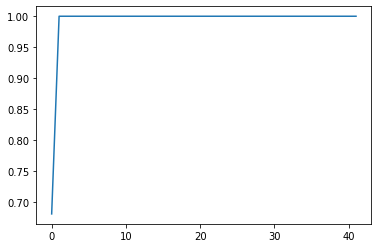

In [27]:
plt.plot(cumsum)

In [91]:
for i in (1, 2, 3, 41):
    print(df[i].value_counts(), end='\n\n')

0    2833545
1    1870598
2     194288
Name: 1, dtype: int64

0     2811660
1     1100831
2      623091
3       96554
4       72653
       ...   
65          3
67          2
68          2
66          2
69          1
Name: 2, Length: 70, dtype: int64

0     3744328
1      869829
2      268874
3        8094
4        5344
5        1040
6         532
7         161
8         122
9          57
10         50
Name: 3, dtype: int64

smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit                 10
loadmodule               9
ftp_write                8
multihop                 7
phf                      4
perl 

In [13]:
for i in (1, 2, 3):
    classes_list = list(dict(df[i].value_counts()).keys())
    classes = {c: i for i, c in enumerate(classes_list)}
    df[i] = df[i].apply(lambda x: classes[x])
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,1,2,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,1,2,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,1,2,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,1,2,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,1,2,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,1,2,0,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,1,2,0,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,1,2,0,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,1,2,0,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


255    3363886
1       117468
2        70459
3        58016
4        55638
        ...   
199        610
202        607
207        547
206        523
0           33
Name: 32, Length: 256, dtype: int64

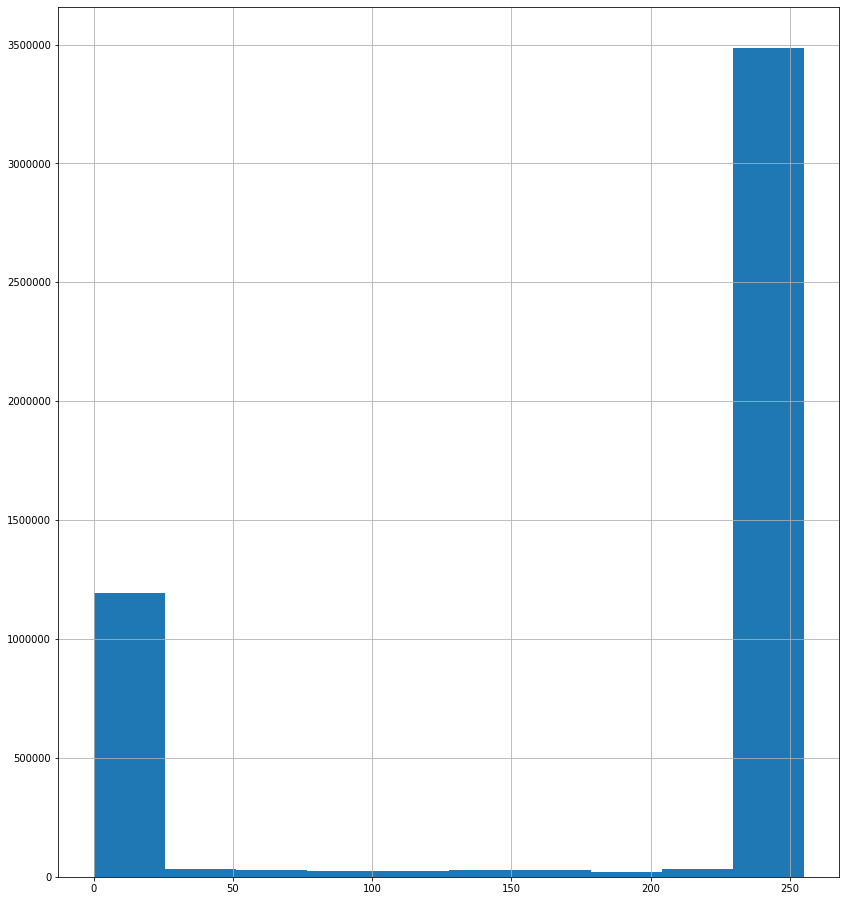

In [15]:
df[32].hist(figsize=(14, 16))
df[32].value_counts()
#plt.show()

In [16]:
#from pandas.plotting import scatter_matrix
#attrs = [1, 4]
#df.plot(kind='scatter', x=1, y=4, figsize=(14, 16))

In [15]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder()
#for i in (1, 2, 3, 41):
#    data_column = df.drop(i, axis=1).values
#    df[i] = encoder.fit_transform(data_column.reshape(-1, 1))
value_counts_dict = df[41].value_counts()
print('+', '-' * 7, '+', '-' * 16, '+', '-' * 8, '+', sep='')
print('|%-6s |%-15s |%-7s |' % ('Class', "Attack type", 'Count'))
print('+', '-' * 7, '+', '-' * 16, '+', '-' * 8, '+', sep='')
for (count, attack_type) in zip(value_counts_dict, value_counts_dict.keys()):
    print('|%-6s |%-15s |%-7d |' % (attack_types_dict[attack_type], attack_type, count))
    print('+', '-' * 7, '+', '-' * 16, '+', '-' * 8, '+', sep='')

+-------+----------------+--------+
|Class  |Attack type     |Count   |
+-------+----------------+--------+
|dos    |smurf           |2807886 |
+-------+----------------+--------+
|dos    |neptune         |1072017 |
+-------+----------------+--------+
|normal |normal          |972781  |
+-------+----------------+--------+
|probe  |satan           |15892   |
+-------+----------------+--------+
|probe  |ipsweep         |12481   |
+-------+----------------+--------+
|probe  |portsweep       |10413   |
+-------+----------------+--------+
|probe  |nmap            |2316    |
+-------+----------------+--------+
|dos    |back            |2203    |
+-------+----------------+--------+
|r2l    |warezclient     |1020    |
+-------+----------------+--------+
|dos    |teardrop        |979     |
+-------+----------------+--------+
|dos    |pod             |264     |
+-------+----------------+--------+
|r2l    |guess_passwd    |53      |
+-------+----------------+--------+
|u2r    |buffer_overflow |30

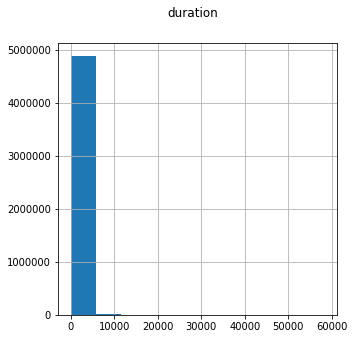

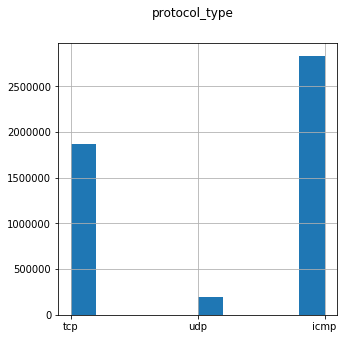

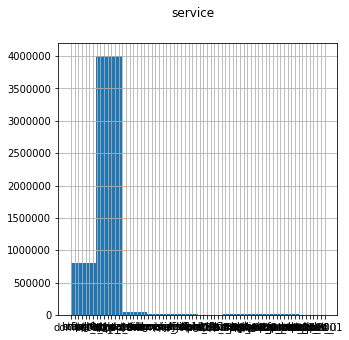

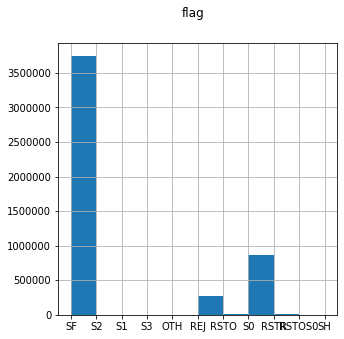

In [16]:
for i in (0, 1, 2, 3):
    df[i].hist(figsize=(5, 5))
    plt.suptitle(features[i])
    plt.show()

In [18]:
df[41].value_counts()

smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit                 10
loadmodule               9
ftp_write                8
multihop                 7
phf                      4
perl                     3
spy                      2
Name: 41, dtype: int64

In [266]:
TRAIN_NUM = 700
TEST_NUM = 200

classes = ['smurf', 'neptune', 'normal', 'satan', 'ipsweep',
           'portsweep', 'nmap', 'back', 'warezclient', 'teardrop']

train_df = df[df[41]==classes[0]][:TRAIN_NUM]
test_df = df[df[41]==classes[0]][TRAIN_NUM:TRAIN_NUM+TEST_NUM]
val_df = df[df[41]==classes[0]][TRAIN_NUM+TEST_NUM:975]

for _class in classes[1:]:
    train_df = train_df.merge(df[df[41]==_class][:TRAIN_NUM], how='outer')
    test_df = test_df.merge(df[df[41]==_class][TRAIN_NUM:TRAIN_NUM+TEST_NUM], how='outer')
    val_df = val_df.merge(df[df[41]==_class][TRAIN_NUM+TEST_NUM:975], how='outer')
print('train_df: ', len(train_df), '\ntest_df:  ', len(test_df), '\nval_df:   ', len(val_df))

train_df:  7000 
test_df:   2000 
val_df:    750


In [267]:
train_df[41].value_counts()

back           700
warezclient    700
portsweep      700
nmap           700
smurf          700
teardrop       700
ipsweep        700
satan          700
normal         700
neptune        700
Name: 41, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
data = train_df.copy()
target = data.pop(41)
rnd_clf.fit(data, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
from sklearn.metrics import accuracy_score

data = test_df.copy()
target = data.pop(41)
test_predicted = rnd_clf.predict(data)
accuracy_score(target, test_predicted)

1.0

In [17]:
data = val_df.copy()
target = data.pop(41)
test_predicted = rnd_clf.predict(data)
accuracy_score(target, test_predicted)

0.932

In [18]:
import numpy as np

i = 0
for (feature, importance) in zip(features_types_dict, rnd_clf.feature_importances_):
    print('%-2d %-28s:' % (i, feature), importance * 100, '%')
    i += 1

0  duration                    : 0.32359199035963016 %
1  protocol_type               : 5.065681373296267 %
2  service                     : 7.139552570589022 %
3  flag                        : 5.05611580765993 %
4  src_bytes                   : 7.994569328800219 %
5  dst_bytes                   : 3.2221180175905437 %
6  land                        : 0.0 %
7  wrong_fragment              : 4.161751392668244 %
8  urgent                      : 0.0 %
9  hot                         : 1.1540446166150968 %
10 num_failed_logins           : 0.0 %
11 logged_in                   : 3.7526721099817104 %
12 num_compromised             : 3.0496164278748834 %
13 root_shell                  : 0.0 %
14 su_attempted                : 0.0 %
15 num_root                    : 0.0015545476367481265 %
16 num_file_creations          : 0.0020542240613386957 %
17 num_shells                  : 6.272426350135718e-07 %
18 num_access_files            : 5.724720135746451e-07 %
19 num_outbound_cmds           : 0.0 %
20 

In [19]:
d = {i: imp for i, imp in enumerate(rnd_clf.feature_importances_)}
for bias in [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    print('>', bias * 100, '%: ', len(list(filter(lambda x: d[x] > bias, d))))

> 0.0 %:  34
> 1.0 %:  26
> 2.0 %:  21
> 3.0 %:  19
> 4.0 %:  11
> 5.0 %:  5
> 6.0 %:  2


In [33]:
data = df[df[41]==classes[-2]][975:976]
data.pop(41)
print('Class: ', classes[-2], '\nPredicted: ', rnd_clf.predict(data))

Class:  warezclient 
Predicted:  ['warezclient']


In [24]:
#for i, f in enumerate(features_types_dict):
#    print('%02d. %010s %s' % (i, features_types_dict[f], f))
#for i in range(42):
#    max_ = df[i].max()
#    print(i, ': ', max_)
#for i in (0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32):
#    max_ = df[i].max()
#    df[i] = df[i].apply(lambda x: x / max_)
#df[41] = df[41].apply(lambda x: target_classes[attack_types_dict[x]])

In [268]:
if input('binary? [Y/N]: ') == 'Y':
    target_classes = {'normal': 0, 'u2r': 1, 'r2l': 1, 'probe': 1, 'dos': 1}
else:
    target_classes = {
        'normal': 0,
        'u2r': 1,
        'r2l': 2,
        'probe': 3,
        'dos': 4
    }

binary? [Y/N]: fg


In [269]:
def df_to_dataset(data, main_df, label_index=41, bias = 0.05, shuffle=True, batch_size=32):
    """
    Performs data preprocessing.
    
    param data: pandas.Dataframe
    """
    df = data.copy()
    for i in range(41):
        if i in cat_attrs:
            df[i], _ = df[i].factorize() # factorize catagorical features
        if i in num_attrs:
            max_ = main_df[i].max()
            df[i] = train_df[i].apply(lambda x: x / max_) # normalize by minimax numeric features
            
    d = {feature: feature_importance for feature, feature_importance in enumerate(rnd_clf.feature_importances_)} 
    df = df.drop(list(filter(lambda x: d[x] < bias, d)), axis=1) # drop unimportance features

    df[label_index] = df[label_index].apply(lambda x: target_classes[attack_types_dict[x]]) # 10 classes > 4 main classes
    df[label_index], _ = df[label_index].factorize()
        
    labels = df.pop(label_index)
    ds = tf.data.Dataset.from_tensor_slices((df.values, labels))
    print(f'Features count: {len(df.columns)}')
    print(labels.value_counts())
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

def labels_to_list(data, label_index=41):
    df = data.copy()
    df[label_index] = df[label_index].apply(lambda x: target_classes[attack_types_dict[x]]) # 10 classes > 4 main classes
    df[label_index], _ = df[label_index].factorize()
    return df[41].values.tolist()

In [270]:
train_df[41].value_counts()

back           700
warezclient    700
portsweep      700
nmap           700
smurf          700
teardrop       700
ipsweep        700
satan          700
normal         700
neptune        700
Name: 41, dtype: int64

In [271]:
if target_classes == {'normal': 0, 'u2r': 1, 'r2l': 1, 'probe': 1, 'dos': 1}:
    EXTRA_NORMAL = 3800
    EXTRA_TEST = 800
    EXTRA_VAL = 400
    
else:
    EXTRA_NORMAL = 1400
    EXTRA_TEST = 400
    EXTRA_VAL = 150

train_df = train_df.merge(df[df[41]=='normal'][-EXTRA_NORMAL:], how='outer')
test_df = test_df.merge(df[df[41]=='normal'][-EXTRA_TEST-EXTRA_NORMAL:-EXTRA_NORMAL], how='outer')
val_df = val_df.merge(df[df[41]=='normal'][-EXTRA_VAL-EXTRA_TEST-EXTRA_NORMAL:-EXTRA_TEST-EXTRA_NORMAL], how='outer')

In [272]:
train_df[41].value_counts()

normal         2100
back            700
warezclient     700
portsweep       700
nmap            700
smurf           700
teardrop        700
ipsweep         700
satan           700
neptune         700
Name: 41, dtype: int64

In [274]:
val_df[41].value_counts()

normal         225
ipsweep         75
satan           75
smurf           75
portsweep       75
nmap            75
teardrop        75
back            75
warezclient     75
neptune         75
Name: 41, dtype: int64

In [227]:
BATCH_SIZE = 32

train_dataset = df_to_dataset(train_df, main_df=df, bias=0.02, batch_size=BATCH_SIZE)
val_dataset = df_to_dataset(val_df, main_df=df, bias=0.02, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(test_df, main_df=df, bias=0.02, batch_size=BATCH_SIZE)

Features count: 14
2    2800
0    2800
1    2100
3     700
Name: 41, dtype: int64
Features count: 14
1    975
2    300
0    300
3     75
Name: 41, dtype: int64
Features count: 14
1    900
2    800
0    800
3    200
Name: 41, dtype: int64


In [228]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [293]:
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [294]:
model = get_compiled_model()
epochs = 30
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    use_multiprocessing=True, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback]
                   )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/30
263/263 [==============================] - 1s 3ms/step - loss: 2.7717 - accuracy: 0.4580 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
263/263 [==============================] - 0s 1ms/step - loss: 1.1808 - accuracy: 0.5598 - val_loss: 0.9673 - val_accuracy: 0.8164
Epoch 3/30
263/263 [==============================] - 0s 1ms/step - loss: 0.9440 - accuracy: 0.6061 - val_loss: 0.8723 - val_accuracy: 0.8382
Epoch 4/30
263/263 [==============================] - 0s 1ms/step - loss: 

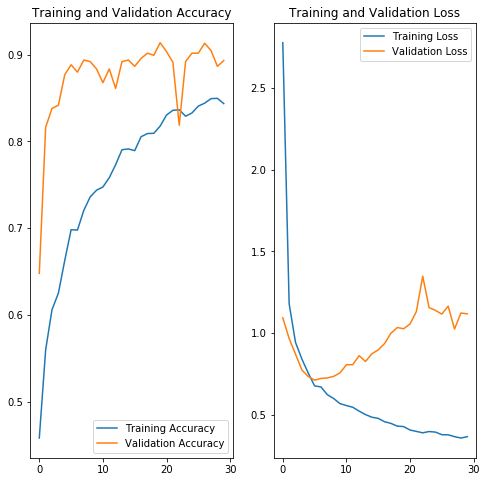

In [296]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [297]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

85/85 [==============================] - 0s 602us/step - loss: 0.4676 - accuracy: 0.8089
Accuracy on test dataset: 0.8088889


In [298]:
from sklearn.metrics import classification_report, confusion_matrix

predict_labels = model.predict(df_to_dataset(test_df, main_df=df, bias=0.02, shuffle=False, batch_size=BATCH_SIZE))
predicted_labels = [np.argmax(predict) for predict in predict_labels]
true_labels = labels_to_list(test_df)
print('Confusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))

Features count: 14
2    800
0    800
1    600
3    200
Name: 41, dtype: int64
Confusion matrix:
 [[607 193   0   0]
 [  2 598   0   0]
 [  0   0 800   0]
 [  0 179   0  21]]
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       800
           1       0.62      1.00      0.76       600
           2       1.00      1.00      1.00       800
           3       1.00      0.10      0.19       200

    accuracy                           0.84      2400
   macro avg       0.90      0.72      0.70      2400
weighted avg       0.90      0.84      0.83      2400



In [105]:
new_test_dataset = df_to_dataset(new_test_df, df, bias=0.04)
test_loss, test_accuracy = model.evaluate(new_test_dataset)
print('Accuracy on test dataset:', test_accuracy)

NameError: name 'new_test_df' is not defined

In [146]:
from sklearn.metrics import accuracy_score

data = test_df.copy()
true_labels = data.pop(41)
predicted_labels = rnd_clf.predict(data)
#accuracy_score(target, test_predicted)

print('Confusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))

Confusion matrix:
 [[ 200    0    0    0    0    0    0    0    0    0]
 [   0  200    0    0    0    0    0    0    0    0]
 [   0    0  200    0    0    0    0    0    0    0]
 [   0    0    0  200    0    0    0    0    0    0]
 [   0    2    0    0 1593    2    2    0    0    1]
 [   0    0    0    0    0  200    0    0    0    0]
 [   0    0    0    0    0    0  200    0    0    0]
 [   0    0    0    0    0    0    0  200    0    0]
 [   0    0    0    0    0    0    0    0  200    0]
 [   0    0    0    0    0    0    0    0    0  200]]
              precision    recall  f1-score   support

        back       1.00      1.00      1.00       200
     ipsweep       0.99      1.00      1.00       200
     neptune       1.00      1.00      1.00       200
        nmap       1.00      1.00      1.00       200
      normal       1.00      1.00      1.00      1600
   portsweep       0.99      1.00      1.00       200
       satan       0.99      1.00      1.00       200
       smurf     

In [147]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
data = df.copy()
target = data.pop(41)
rnd_clf.fit(data, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [148]:
data = test_df.copy()
true_labels = data.pop(41)
predicted_labels = rnd_clf.predict(data)
#accuracy_score(target, test_predicted)

print('Confusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))

Confusion matrix:
 [[ 200    0    0    0    0    0    0    0    0    0]
 [   0  200    0    0    0    0    0    0    0    0]
 [   0    0  200    0    0    0    0    0    0    0]
 [   0    0    0  200    0    0    0    0    0    0]
 [   0    0    0    0 1600    0    0    0    0    0]
 [   0    0    0    0    0  200    0    0    0    0]
 [   0    0    0    0    0    0  200    0    0    0]
 [   0    0    0    0    0    0    0  200    0    0]
 [   0    0    0    0    0    0    0    0  200    0]
 [   0    0    0    0    0    0    0    0    0  200]]
              precision    recall  f1-score   support

        back       1.00      1.00      1.00       200
     ipsweep       1.00      1.00      1.00       200
     neptune       1.00      1.00      1.00       200
        nmap       1.00      1.00      1.00       200
      normal       1.00      1.00      1.00      1600
   portsweep       1.00      1.00      1.00       200
       satan       1.00      1.00      1.00       200
       smurf     

In [158]:
classes = list(df[41].value_counts().keys())
df[41].value_counts()

smurf              2807886
neptune            1072017
normal              972781
satan                15892
ipsweep              12481
portsweep            10413
nmap                  2316
back                  2203
warezclient           1020
teardrop               979
pod                    264
guess_passwd            53
buffer_overflow         30
land                    21
warezmaster             20
imap                    12
rootkit                 10
loadmodule               9
ftp_write                8
multihop                 7
phf                      4
perl                     3
spy                      2
Name: 41, dtype: int64

In [162]:
classes[1:11], classes[11:]

(['neptune',
  'normal',
  'satan',
  'ipsweep',
  'portsweep',
  'nmap',
  'back',
  'warezclient',
  'teardrop',
  'pod'],
 ['guess_passwd',
  'buffer_overflow',
  'land',
  'warezmaster',
  'imap',
  'rootkit',
  'loadmodule',
  'ftp_write',
  'multihop',
  'phf',
  'perl',
  'spy'])

In [164]:
new_train_df = df[df[41]==classes[0]][-200:]

for _class in classes[1:11]:
    new_train_df = new_train_df.merge(df[df[41]==_class][-200:], how='outer')
for _class in classes[11:]:
    new_train_df = new_train_df.merge(df[df[41]==_class], how='outer')
len(new_train_df)

2379

In [165]:
data = new_train_df.copy()
true_labels = data.pop(41)
predicted_labels = rnd_clf.predict(data)
#accuracy_score(target, test_predicted)

print('Confusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))

Confusion matrix:
 [[200   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0  53   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0 200   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0  21   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   9   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   7   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 200   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0  